In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
from tqdm import tqdm
#%matplotlib inline

In [2]:
def build_tables(pre_df):
    # using this as the only place to pull pre-syn's from because it's well-proofread
    presyn_df = ['allen_v1_column_types_slanted']
    df = client.materialize.query_table(presyn_df[0],split_positions=True)
    # post-synaptic partners of starter cell
    pre_root_id = np.array(pre_df.pt_root_id)[0]
    syn_unfiltered = client.materialize.query_table('synapses_pni_2',
                                                filter_equal_dict={'pre_pt_root_id':pre_root_id})
    # if updated, this will change
    correct_soma_table = client.info.get_datastack_info()['soma_table']
    # x, y, and z will have their own columns
    nuclei_unmasked = client.materialize.query_table(correct_soma_table,split_positions=True)
    # new df of just neurons (no glial cells)
    nuclei = nuclei_unmasked.query('cell_type == "neuron"').reset_index(drop=True)
    # new column saying how many neurons have the same root_id
    nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
    # mask the df to throw out merged nuclei (same root_id being assigned to multiple neurons)
    mask_nuclei = nuclei['num_soma'] < 2
    nuclei_full = nuclei[mask_nuclei].reset_index(drop=True)
    # grabbing the unique root_id's of single-body neurons
    unique_nuc = np.unique(nuclei_full.pt_root_id)
    # masking the cell type table for only single-body neurons
    soma_full = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',
                                               filter_in_dict = {'pt_root_id':unique_nuc},
                                               split_positions=True)
    # masking the synapse table for only single-body neurons. these contain a ton of duplicates
    syn_nuc_dup = syn_unfiltered.query("post_pt_root_id in @unique_nuc").reset_index(drop=True)
    # new column in synapse table = number of synapses per single soma
    syn_nuc_dup['num_syn'] = syn_nuc_dup.groupby('post_pt_root_id').transform('count')['valid']
    syn_nuc_dup = syn_nuc_dup.sort_values(by=['post_pt_root_id']).reset_index(drop=True)
    # renaming bc 'size' is a function and it messes with grouping
    syn_nuc_dup.rename(columns={'size':'sizes'}, inplace=True)
    # dropping duplicates
    syn_nuc = syn_nuc_dup.drop_duplicates(subset='post_pt_root_id', keep='first').reset_index(drop=True)
    # grabbing every synaptic size and position and stacking them into a tuple so that each unique nucleus has a list of syn sizes
    syn_nuc['ctr_pt_position'] = syn_nuc_dup.assign(ctr_pt_position=tuple(syn_nuc_dup.ctr_pt_position)).groupby('post_pt_root_id').ctr_pt_position.apply(list).reset_index(drop=True)
    syn_nuc['sizes'] = syn_nuc_dup.assign(sizes=tuple(syn_nuc_dup.sizes)).groupby('post_pt_root_id').sizes.apply(list).reset_index(drop=True)
    syn_nuc['sum_size'] = syn_nuc.apply(lambda row: sum(row.sizes), axis=1)
    syn_nuc['ave_size'] = syn_nuc.apply(lambda row: row.sum_size / len(row.sizes), axis=1)
    # renaming post_pt_root_id in order to merge correctly
    syn_nuc.rename(columns={'post_pt_root_id':'pt_root_id'}, inplace=True)
    # merge!
    main = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='left')
    # these columns are useless to me
    main = main.drop(columns=['id_x', 'id_y', 'valid_x', 'valid_y', 'pt_supervoxel_id', 'pre_pt_supervoxel_id', 
                          'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])
    main = main.fillna(0)
    # add new columns for cartesian & radial distance to root_id's 
    main['d'] = Cartdistance_cell2cell(pre_df,main)
    main['r'] = Raddistance_cell2cell(pre_df,main)
    main['d_syn2pre'] = Cartdistance_syn2cell(main,pre_df)
    main['r_syn2pre'] = Raddistance_syn2cell(main,pre_df)
    main['d_syn2post'] = Cartdistance_syn2cell(main,main)
    main['r_syn2post'] = Raddistance_syn2cell(main,main)
    # grabbing the unique root_id's of single-body neurons in the synapse table
    unique_syn_nuc = np.unique(syn_nuc.pt_root_id)
    # new tables sorted from main of synaptic targets or non-synaptic neighbors of pre_root_id
    syn = main.query('pt_root_id in @unique_syn_nuc').reset_index(drop=True)
    nonsyn = main.query('pt_root_id not in @unique_syn_nuc').reset_index(drop=True)
    return main,syn,nonsyn

In [3]:
def type_spitter(main,df):
    types = np.unique(main.cell_type)
    cellarray = []
    for i in range(len(types)):
        new = df.query(f"cell_type in @types[{i}]").reset_index(drop=True)
        cellarray.append(new)
    return cellarray

In [4]:
def Cartdistance_cell2cell(pre,post):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_pre,y_pre,z_pre = pre.pt_position_x.values*xy,pre.pt_position_y.values*xy,pre.pt_position_z.values*z
    x_pos,y_pos,z_pos = post.pt_position_x.values*xy,post.pt_position_y.values*xy,post.pt_position_z.values*z
    d = np.zeros(len(post))
    for i in range(len(post)):
        d[i] = np.around(np.sqrt((x_pre-x_pos[i])**2 + (y_pre-y_pos[i])**2 + (z_pre-z_pos[i])**2),3)
    return d

def Raddistance_cell2cell(pre,post):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_pre,z_pre = pre.pt_position_x.values*xy,pre.pt_position_z.values*z
    x_pos,z_pos = post.pt_position_x.values*xy,post.pt_position_z.values*z
    d = np.zeros(len(post))
    for i in range(len(post)):
        d[i] = np.around(np.sqrt((x_pre-x_pos[i])**2 + (z_pre-z_pos[i])**2),3)
    return d


def Cartdistance_syn2cell(syn_df,cell):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_cell,y_cell,z_cell = cell.pt_position_x.values*xy,cell.pt_position_y.values*xy,cell.pt_position_z.values*z
    distance = []
    for i in range(len(syn_df)):
        d = []
        if syn_df.ctr_pt_position[i] == 0:
            d.append(0)
        else:
            for j in range(len(np.array(syn_df.ctr_pt_position[i]))):
                x_syn = np.array(syn_df.ctr_pt_position[i])[j][0]*xy
                y_syn = np.array(syn_df.ctr_pt_position[i])[j][1]*xy
                z_syn = np.array(syn_df.ctr_pt_position[i])[j][2]*z
                if len(cell) == 1:
                    dsyn = np.sqrt((x_syn-x_cell[0])**2 + (y_syn-y_cell[0])**2 + (z_syn-z_cell[0])**2)
                else:
                    dsyn = np.sqrt((x_syn-x_cell[i])**2 + (y_syn-y_cell[i])**2 + (z_syn-z_cell[i])**2)
                d.append(np.around(dsyn,3))
        distance.append(d)
    return distance

def Raddistance_syn2cell(syn_df,cell):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_cell,z_cell = cell.pt_position_x.values*xy,cell.pt_position_z.values*z
    distance = []
    for i in range(len(syn_df)):
        d = []
        if syn_df.ctr_pt_position[i] == 0:
            d.append(0)
        else:
            for j in range(len(np.array(syn_df.ctr_pt_position[i]))):
                x_syn = np.array(syn_df.ctr_pt_position[i])[j][0]*xy
                z_syn = np.array(syn_df.ctr_pt_position[i])[j][2]*z
                if len(cell) == 1:
                    dsyn = np.sqrt((x_syn-x_cell[0])**2 + (z_syn-z_cell[0])**2)
                else:
                    dsyn = np.sqrt((x_syn-x_cell[i])**2 + (z_syn-z_cell[i])**2)
                d.append(np.around(dsyn,3))
        distance.append(d)
    return distance

In [5]:
def prep_tables(pre_df,main,syn,nonsyn,r_interval,upper_distance_limit):
    main_types = type_spitter(main,main)
    syn_types = type_spitter(main,syn)
    nonsyn_types = type_spitter(main,nonsyn)
    
    bins = np.array(range(0,upper_distance_limit,r_interval))
    f_type,s_type = [],[]
    for j in range(len(main_types)):
        f,s = binomial_CI(main_types[j],bins)
        f_type.append(f)
        s_type.append(s)
    return main_types,syn_types,nonsyn_types,f_type,s_type

def prep_tables_thresh(pre_df,main,syn,nonsyn,r_interval,upper_distance_limit,threshold):
    main['thresh'] = main.apply(lambda row: np.min(row.d_syn2post) < threshold, axis=1)
    syn['thresh'] = syn.apply(lambda row: np.min(row.d_syn2post) < threshold, axis=1)
    mask_m = main['thresh'] == True
    mask_s = syn['thresh'] == True
    main_thresh = main[mask_m].reset_index(drop=True)
    syn_thresh = syn[mask_s].reset_index(drop=True)
    
    main_types_thresh = type_spitter(main_thresh,main_thresh)
    syn_types_thresh = type_spitter(main_thresh,syn_thresh)
    
    bins = np.array(range(0,upper_distance_limit,r_interval))
    f_type_thresh,s_type_thresh = [],[]
    for j in range(len(main_types_thresh)):
        f,s = binomial_CI(main_types_thresh[j],bins)
        f_type_thresh.append(f)
        s_type_thresh.append(s)
    return main_thresh,syn_thresh,main_types_thresh,syn_types_thresh,f_type_thresh,s_type_thresh

In [6]:
def binomial_CI(df, bins):
    fail = []
    success = []
    # no cells are less than 0 microns away, and this makes sure my arrays are the same size
    fail.append(0)
    success.append(0)
    for i in range(len(bins)-1):
        # masking for specific distance bin
        masked_df = df[(df['r'] < bins[i+1]) & (df['r'] > bins[i])].reset_index(drop=True)
        # starting the counter
        f,s = 0,0
        for j in range(len(masked_df)):
            if masked_df['pre_pt_root_id'][j] == 0:
                f += 1
            else:
                s += 1
        # if there are zero cells in masked_df, 0's are appended
        fail.append(f)
        success.append(s)
    return np.array(fail),np.array(success)

In [7]:
def threepanels_pertype(pre,syn_types,nonsyn_types,s_type,f_type,unique_types,r_interval,upper_distance_limit,filename):
    warnings.filterwarnings('ignore')

    fig, ax = plt.subplots(len(unique_types),3)
    fig.set_size_inches(12,26)
    
    bins = np.array(range(0,upper_distance_limit,r_interval))
    x = bins-(r_interval/2)
    for i in range(len(unique_types)):
        sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
                        ax=ax[i,0], color='grey', alpha=.4, s=10)
        sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
                        ax=ax[i,0], color='b', alpha=.9, s=10).set_xlabel(r'$\mu$m (x vs z)')
        sns.scatterplot(x=pre.pt_position_x*(4/1000), y=pre.pt_position_z*(40/1000), marker='*',color='r',s=200,
                        ax=ax[i,0]).set_ylabel(unique_types[i], fontsize=16)
        xrange = [int(pre.pt_position_x*(4/1000))-250,int(pre.pt_position_x*(4/1000))+250]
        yrange = [int(pre.pt_position_z*(40/1000))-250,int(pre.pt_position_z*(40/1000))+250]
        ax[i,0].set_xlim(xrange[0],xrange[1])
        ax[i,0].set_ylim(yrange[0],yrange[1])
        ax[i,0].set_aspect('equal')

        method = 'wilson'
        errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i]+f_type[i]),method=method)
        probability = (s_type[i]/(f_type[i]+s_type[i]))
        ax[i,1].scatter(x=x, y=probability)
        ax[i,1].errorbar(x=x, y=probability, yerr=(probability-errorbars[0],errorbars[1]-probability), fmt='-o') 
        ax[i,1].set_xlabel(r'$\mu$m (radial)', fontsize=10)
        ax[i,1].set_ylabel("Probability of Connection", fontsize=10)
        ax[i,1].set_ylim(-0.1,1.)
        ax[i,1].grid()

        ax[i,2].hist(x,bins=len(bins),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
        ax[i,2].hist(x,bins=len(bins),weights=s_type[i],density=False,label='Synaptic', color='blue')
        ax[i,2].set_yscale('log')
        ax[i,2].set_xlabel(r'$\mu$m (radial)', fontsize=10)
        ax[i,2].set_xlim(-10,(max(bins)+10))
        ax[i,2].grid()
        ax[i,2].set_ylabel("Log Frequency", fontsize=10)

    fig.tight_layout()
    plt.close(fig)
    fig.savefig('./plots/{0:s}/{1:s}.pdf'.format(str(pre.cell_type.values[0]),filename))
    
def makeplots(pre,syn,syn_types,nonsyn_types,s_type,f_type,r_interval,upper_distance_limit,threshold):
    if threshold == None:
        for i in tqdm(range(len(pre))):
            # this will give filename = 'BC-4587604586048560456748'
            filename = '{0:s}-{1:s}'.format(str(np.array(pre[i].cell_type)[0]),str(np.array(pre[i].pt_root_id)[0]))
            unique_types = np.unique(syn[i].cell_type)
            threepanels_pertype(pre[i],syn_types[i],nonsyn_types[i],s_type[i],f_type[i],
                                unique_types,r_interval,upper_distance_limit,filename)
    else:
        for i in tqdm(range(len(pre))):
            # this will give filename = 'BC-4587604586048560456748'
            filename = '{0:s}-{1:s}-{2:s}'.format(str(np.array(pre[i].cell_type)[0]),str(threshold),str(np.array(pre[i].pt_root_id)[0]))
            unique_types = np.unique(syn[i].cell_type)
            threepanels_pertype(pre[i],syn_types[i],nonsyn_types[i],s_type[i],f_type[i],
                                unique_types,r_interval,upper_distance_limit,filename)

In [46]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [47]:
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)

In [107]:
pre_root_ids = [864691135428608048]
pre = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pre.append(pre_grab)

In [48]:
np.unique(df.cell_type)

array(['23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6IT', '6P', 'BC',
       'BPC', 'MC', 'NGC', 'Unsure'], dtype=object)

In [112]:
pre = []
pre_df = df.query("cell_type == '5P_IT'").reset_index(drop=True)
for i in range(len(pre_df)):
    p = pre_df.iloc[[i]]
    pre.append(p)

In [113]:
len(pre)

129

In [ ]:
main,syn,nonsyn = [],[],[]
badroots = []
for i in tqdm(range(len(pre))):
    try:
        m,s,n = build_tables(pre[i])
        main.append(m)
        syn.append(s)
        nonsyn.append(n)
    except:
        badroots.append(pre[i])
        continue

In [117]:
r = 25
up = 400
threshold = 40
main_types,syn_types,nonsyn_types,f_type,s_type = [],[],[],[],[]
main_thresh,syn_thresh,main_types_thresh,syn_types_thresh,f_type_thresh,s_type_thresh = [],[],[],[],[],[]
for i in tqdm(range(len(pre))):
    beh = prep_tables(pre[i],main[i],syn[i],nonsyn[i],r,up)
    main_types.append(beh[0])
    syn_types.append(beh[1])
    nonsyn_types.append(beh[2])
    f_type.append(beh[3])
    s_type.append(beh[4])
    
    bep = prep_tables_thresh(pre[i],main[i],syn[i],nonsyn[i],r,up,threshold)
    main_thresh.append(bep[0])
    syn_thresh.append(bep[1])
    main_types_thresh.append(bep[2])
    syn_types_thresh.append(bep[3])
    f_type_thresh.append(bep[4])
    s_type_thresh.append(bep[5])

100%|█████████████████████████████████████████| 129/129 [14:15<00:00,  6.63s/it]


In [118]:
makeplots(pre,main,syn_types,nonsyn_types,s_type,f_type,r,up,None)
makeplots(pre,main,syn_types_thresh,nonsyn_types,s_type_thresh,f_type_thresh,r,up,40)

 19%|████████▏                                 | 25/129 [05:24<22:30, 12.99s/it]


KeyboardInterrupt: 

In [105]:
len(syn[5])

54

In [55]:
def findorphan_rootids(pre_df):
    syn_unfiltered = client.materialize.query_table('synapses_pni_2',
                                                filter_equal_dict={'pre_pt_root_id':pre_df.pt_root_id.values[0]})
    correct_soma_table = client.info.get_datastack_info()['soma_table']
    nuclei_unmasked = client.materialize.query_table(correct_soma_table,split_positions=True)
    # new df of just neurons (no glial cells)
#     nuclei = nuclei_unmasked.query('cell_type == "neuron"').reset_index(drop=True)
#     # new column saying how many neurons have the same root_id
#     nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
#     # mask the df to throw out merged nuclei (same root_id being assigned to multiple neurons)
#     mask_nuclei = nuclei['num_soma'] < 2
#     nuclei_full = nuclei[mask_nuclei].reset_index(drop=True)
    unique_nuc = np.unique(nuclei_unmasked.pt_root_id)
    syn_orphans = syn_unfiltered.query("post_pt_root_id not in @unique_nuc").reset_index(drop=True)
    unique_orphans = np.unique(syn_orphans.post_pt_root_id)
    uniq_orph = np.array_split(unique_orphans,len(unique_orphans))
    return syn_orphans,uniq_orph

In [106]:
orph,orph_rootids = findorphan_rootids(pre[5])
print("\nThere are {0:d} post-synaptic connections to {1:d} unique orphaned root_ids.".format(len(orph),len(orph_rootids)))


There are 17 post-synaptic connections to 16 unique orphaned root_ids.


In [89]:
orph = orph.drop(columns=['id', 'valid', 'pre_pt_supervoxel_id', 
                          'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])

In [90]:
orph = orph.sort_values(by=['post_pt_root_id']).reset_index(drop=True)
orph['num_syn'] = orph.groupby('post_pt_root_id')['post_pt_root_id'].transform('count')
orph.rename(columns={'size':'sizes'}, inplace=True)

In [91]:
osyn = orph.drop_duplicates(subset='post_pt_root_id', keep='first').reset_index(drop=True)

In [92]:
osyn['ctr_pt_position'] = orph.assign(ctr_pt_position=tuple(orph.ctr_pt_position)).groupby('post_pt_root_id').ctr_pt_position.apply(list).reset_index(drop=True)
osyn['sizes'] = orph.assign(sizes=tuple(orph.sizes)).groupby('post_pt_root_id').sizes.apply(list).reset_index(drop=True)

In [93]:
osyn['sum_size'] = osyn.apply(lambda row: sum(row.sizes), axis=1)
osyn['ave_size'] = osyn.apply(lambda row: row.sum_size / len(row.sizes), axis=1)

In [94]:
osyn['d'] = Cartdistance_syn2cell(osyn,pre[0])
osyn['r'] = Raddistance_syn2cell(osyn,pre[0])

In [95]:
osyn['d_ave'] = osyn.apply(lambda row: sum(row.d)/len(row.d), axis=1)
osyn['d_range'] = osyn.apply(lambda row: np.max(row.d) - np.min(row.d), axis=1)
osyn['r_ave'] = osyn.apply(lambda row: sum(row.r)/len(row.r), axis=1)
osyn['r_range'] = osyn.apply(lambda row: np.max(row.r) - np.min(row.r), axis=1)

In [96]:
osyn[0:3]

,pre_pt_root_id,post_pt_root_id,sizes,ctr_pt_position,num_syn,sum_size,ave_size,d,r,d_ave,d_range,r_ave,r_range
0,864691135355207375,864691133332252225,[2740],"[[186197, 224332, 23024]]",1,2740,2740.0,[61.859],[22.1],61.859,0.0,22.100,0.0
1,864691135355207375,864691133459131351,[2316],"[[196346, 215778, 21301]]",1,2316,2316.0,[68.971],[64.822],68.971,0.0,64.822,0.0
2,864691135355207375,864691133668625599,[16588],"[[183484, 214834, 21543]]",1,16588,16588.0,[64.128],[61.0],64.128,0.0,61.000,0.0


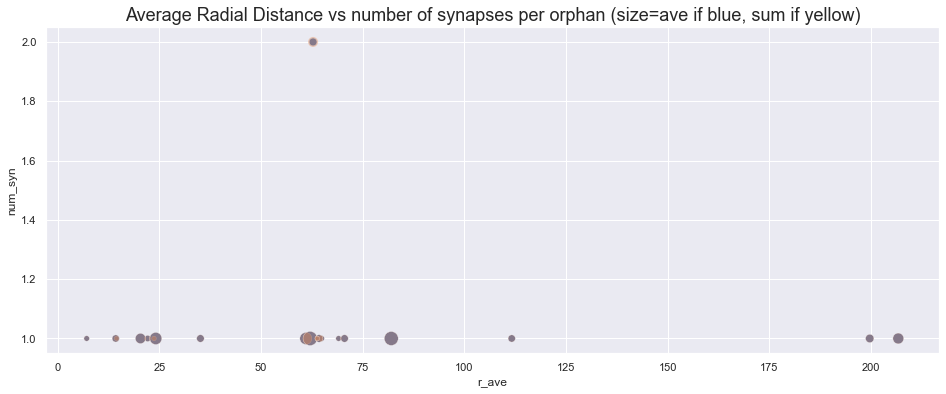

In [97]:
sns.set(rc={'figure.figsize':(16,6)})
#weight = osyn.eval("num_syn / 40").rename("weight")
g = sns.scatterplot(data=osyn,x='r_ave',y='num_syn',size='ave_size', sizes=(20, 200), legend= False);
sns.scatterplot(data=osyn,x='r_ave',y='num_syn',size='sum_size', sizes=(20, 200), legend= False, alpha=.4)
#sns.scatterplot(data=osyn,x='d_ave',y='num_syn',size='ave_size', sizes=(20, 200), legend= False)
#g.set(xlim=(0, 250));
#g.set(ylim=(0, 20));
g.set_title('Average Radial Distance vs number of synapses per orphan (size=ave if blue, sum if yellow)', fontsize=18);

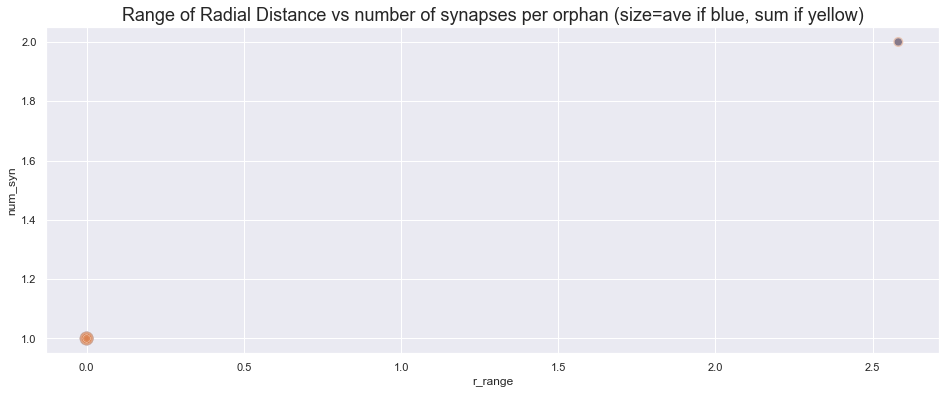

In [98]:
sns.set(rc={'figure.figsize':(16,6)})
#weight = osyn.eval("num_syn / 40").rename("weight")
g = sns.scatterplot(data=osyn,x='r_range',y='num_syn',size='ave_size', sizes=(20, 200), legend= False);
sns.scatterplot(data=osyn,x='r_range',y='num_syn',size='sum_size', sizes=(20, 200), legend= False, alpha=.4)
#sns.scatterplot(data=osyn,x='d_ave',y='num_syn',size='ave_size', sizes=(20, 200), legend= False)
#g.set(xlim=(0, 250));
#g.set(ylim=(0, 20));
g.set_title('Range of Radial Distance vs number of synapses per orphan (size=ave if blue, sum if yellow)', fontsize=18);

In [70]:
ox,oy,oz = [],[],[]
for i in range(len(orph)):
    x = np.array(orph.ctr_pt_position[i])[0]*(4/1000)
    y = np.array(orph.ctr_pt_position[i])[1]*(4/1000)
    z = np.array(orph.ctr_pt_position[i])[2]*(40/1000)
    ox.append(x)
    oy.append(y)
    oz.append(z)

In [71]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [76]:
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(1, 2)
# fig = plt.figure(figsize=(18,8))

# sns.set_theme(style="ticks")
# g0 = sns.jointplot(x=ox, y=oz, kind='hex',color="#4CB391")
# #g0.set_title("Position of Orphan Synapses", fontsize=16);
# sns.scatterplot(x=pre[0].pt_position_x*(4/1000),y=pre[0].pt_position_z*(40/1000),marker='*',color='r',s=300).set_xlim(490,1130)

# g1 = sns.jointplot(x=syn[0].pt_position_x*(4/1000), y=syn[0].pt_position_z*(40/1000),kind='hex',color="#4CB391")
# sns.scatterplot(x=pre[0].pt_position_x*(4/1000),y=pre[0].pt_position_z*(40/1000),marker='*',color='r',s=300).set_ylim(700,1130)

# mg0 = SeabornFig2Grid(g0, fig, gs[0])
# mg1 = SeabornFig2Grid(g1, fig, gs[1])

# gs.tight_layout(fig)

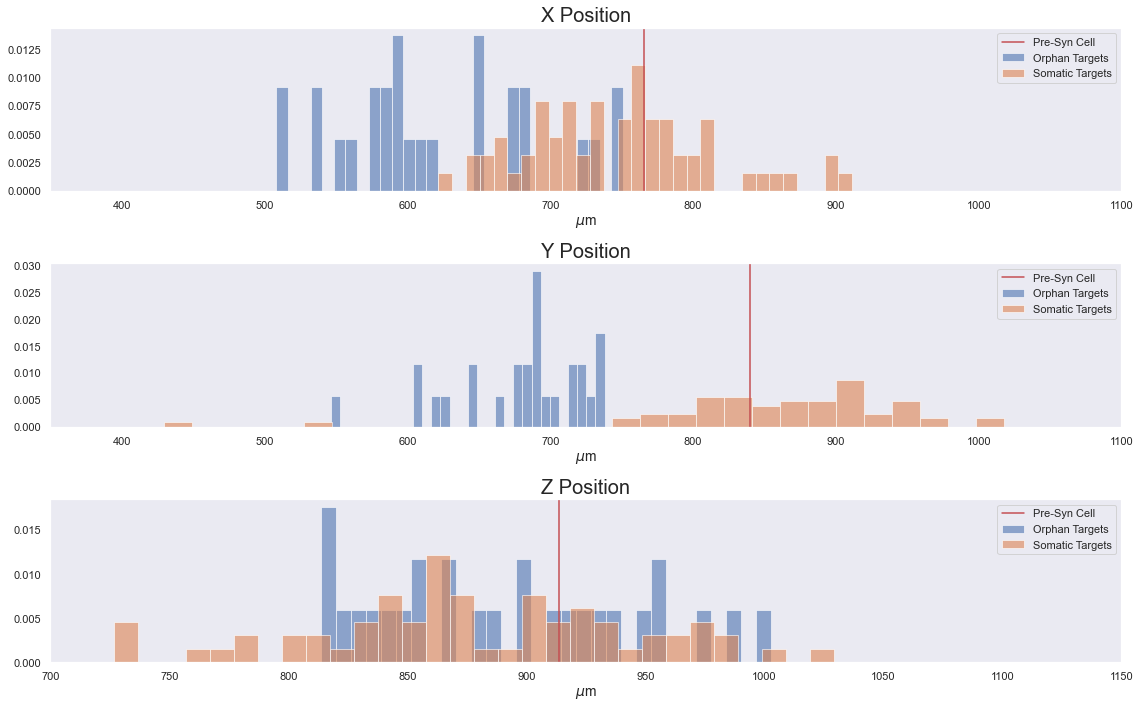

In [99]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(16,10)

ax[0].hist(ox, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[0].hist(syn[0]['pt_position_x']*(4/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[0].axvline(np.array(pre[0]['pt_position_x']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[0].set_title("X Position", fontsize=20)
ax[0].set_xlabel(r'$\mu$m', fontsize=14)
ax[0].legend()
ax[0].grid()

ax[1].hist(oy, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[1].hist(syn[0]['pt_position_y']*(4/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[1].axvline(np.array(pre[0]['pt_position_y']*(4/1000))[0], label='Pre-Syn Cell', c='r')
ax[1].set_title("Y Position", fontsize=20)
ax[1].set_xlabel(r'$\mu$m', fontsize=14)
ax[1].legend()
ax[1].grid()

ax[2].hist(oz, 30, label='Orphan Targets', density=True, alpha=0.6)
ax[2].hist(syn[0]['pt_position_z']*(40/1000), 30, label='Somatic Targets', density=True, alpha=0.6)
ax[2].axvline(np.array(pre[0]['pt_position_z']*(40/1000))[0], label='Pre-Syn Cell', c='r')
ax[2].set_title("Z Position", fontsize=20)
ax[2].set_xlabel(r'$\mu$m', fontsize=14)
ax[2].legend()
ax[2].grid()

ax[0].set_xlim(350,1100)
ax[1].set_xlim(350,1100)
ax[2].set_xlim(700,1150)

plt.tight_layout()
plt.show()

In [22]:
# o = []
# for i in tqdm(range(len(orph_rootids))):
#     orphans = client.materialize.query_table('synapses_pni_2',
#                                              select_columns=['pre_pt_root_id','post_pt_root_id','size','ctr_pt_position'],
#                                                filter_equal_dict={'post_pt_root_id':orph_rootids[i][0]})
#     o.append(orphans)

In [23]:
#o_df = pd.concat(o,ignore_index=True)
#o_df = o_df.drop(columns=['id', 'valid', 'pre_pt_supervoxel_id', 'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])

In [24]:
#o_df.to_pickle("./BC-orphans.pkl")

In [25]:
#o_dup = pd.read_pickle('./BC-orphans.pkl')

In [26]:
o_dup = o_dup.drop(columns=['id', 'valid', 'pre_pt_supervoxel_id', 
                          'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])

NameError: name 'o_dup' is not defined

In [ ]:
o_dup = o_dup.sort_values(by=['post_pt_root_id']).reset_index(drop=True)
o_dup['num_syn'] = o_dup.groupby('post_pt_root_id')['post_pt_root_id'].transform('count')
o_dup.rename(columns={'size':'sizes'}, inplace=True)

In [ ]:
o = o_dup.drop_duplicates(subset='post_pt_root_id', keep='first').reset_index(drop=True)

In [ ]:
o['pre_pt_root_id'] = o_dup.assign(pre_pt_root_id=tuple(o_dup.pre_pt_root_id)).groupby('post_pt_root_id').pre_pt_root_id.apply(list).reset_index(drop=True)

In [ ]:
o['ctr_pt_position'] = o_dup.assign(ctr_pt_position=tuple(o_dup.ctr_pt_position)).groupby('post_pt_root_id').ctr_pt_position.apply(list).reset_index(drop=True)
o['sizes'] = o_dup.assign(sizes=tuple(o_dup.sizes)).groupby('post_pt_root_id').sizes.apply(list).reset_index(drop=True)

In [ ]:
#o_dup#.sort_values(by=['pre_pt_root_id']).reset_index(drop=True)
blbl = np.unique(o_dup.pre_pt_root_id)
print("There are {0:d} other pre-synaptic connections to the orphaned root id's.".format(len(blbl)))

In [ ]:
o[0:3]#.sort_values(by=['pre_pt_root_id']).reset_index(drop=True)

In [ ]:
o['d_syn2pre'] = Cartdistance_syn2cell(o,pre[0])

In [ ]:
o['r_syn2pre'] = Raddistance_syn2cell(o,pre[0])

#### Should I find the distance to the other pre-synaptic connections? (would involve querying the soma table for 2.3 million neurons. I suppose some might not even be neurons)

- ~method~
- ~depth slices~
- ~depth vs radial distance~
- ~add synapse locations to root_id in table~
- ~add average synapse size to root_id in table~
- ~array of distances for synapse to target (and synapse to pre_syn)~
- quantify orphan targets, add uncertainty OR assign to excitatory
- ~make the same plots but only for synapses within 40 µm of their target cell body position~
- make the same plots but scale color w snapse count
- add ave synapse size to depth vs radial distance plots
- distribution of total number of synapses from the starter cell onto those cells per cell type
- calculate angle to target cells from pre_synaptic cell / determine axon angle
- measure drop-off of axon/dendrite overlap

- normalize hist?
- target cell's synapse position info? spread? volume?

### From Casey:

Orphans will happen, in principle, when the root id does not show up in the nucleus_neuron_svm table. 

There are two basic possibilities for an orphan:
1. The orphan should connect to a cell in the dataset but there is an error in the segmentation that needs proofreading
2. The orphan is a true orphan, part of a cell outside the dataset volume.

For our measurements, Category 1 breaks down into more cateogries:

    1a) Other synapses from the orphan's true host are accounted for, so the orphan will only add to the synapse count
    
    1b) The segmented cell does not receive other synapses from the seed interneuron, and thus there is a false lack of connection in the data until the orphan is attached.

These all will have spatial biases (more orphans close to the dataset edge) and morphology biases (neurons that target cell bodies might have fewer orphans of type 1b, because dendrite fragments tend to start farther out on the cell)

I suspect we will have to actually do some manual counting of these, in order to quantify our uncertainty